In [ ]:
import sys
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !git clone https://github.com/YuanGongND/ast
    sys.path.append('./ast')
%cd /content/ast/

! pip install timm==0.4.5
! pip install wget
import os, csv, argparse, wget
os.environ['TORCH_HOME'] = '/content/ast/pretrained_models'
if os.path.exists('/content/ast/pretrained_models') == False:
  os.mkdir('/content/ast/pretrained_models')
import torch, torchaudio, timm
import numpy as np
from torch.cuda.amp import autocast
import IPython

Running in Colab.
fatal: destination path 'ast' already exists and is not an empty directory.
/content/ast


In [ ]:
from src.models import ASTModel

# Create a new class that inherits the original ASTModel class
class ASTModelVis(ASTModel):
    def get_att_map(self, block, x):
        qkv = block.attn.qkv
        num_heads = block.attn.num_heads
        scale = block.attn.scale
        B, N, C = x.shape
        qkv = qkv(x).reshape(B, N, 3, num_heads, C // num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)
        attn = (q @ k.transpose(-2, -1)) * scale
        attn = attn.softmax(dim=-1)
        return attn

    def forward_visualization(self, x):
        # expect input x = (batch_size, time_frame_num, frequency_bins), e.g., (12, 1024, 128)
        x = x.unsqueeze(1)
        x = x.transpose(2, 3)

        B = x.shape[0]
        x = self.v.patch_embed(x)
        cls_tokens = self.v.cls_token.expand(B, -1, -1)
        dist_token = self.v.dist_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, dist_token, x), dim=1)
        x = x + self.v.pos_embed
        x = self.v.pos_drop(x)
        # save the attention map of each of 12 Transformer layer
        att_list = []
        for blk in self.v.blocks:
            cur_att = self.get_att_map(blk, x)
            att_list.append(cur_att)
            x = blk(x)
        return att_list

def make_features(wav_name, mel_bins, target_length=1024):
    waveform, sr = torchaudio.load(wav_name)
    waveform = torchaudio.functional.resample(waveform, orig_freq=sr, new_freq=16000)
    # assert sr == 16000, 'input audio sampling rate must be 16kHz'

    fbank = torchaudio.compliance.kaldi.fbank(
        waveform, htk_compat=True, sample_frequency=sr, use_energy=False,
        window_type='hanning', num_mel_bins=mel_bins, dither=0.0, frame_shift=10)

    n_frames = fbank.shape[0]

    p = target_length - n_frames
    if p > 0:
        m = torch.nn.ZeroPad2d((0, 0, 0, p))
        fbank = m(fbank)
    elif p < 0:
        fbank = fbank[0:target_length, :]

    fbank = (fbank - (-4.2677393)) / (4.5689974 * 2)
    return fbank

def load_label(label_csv):
    with open(label_csv, 'r') as f:
        reader = csv.reader(f, delimiter=',')
        lines = list(reader)
    labels = []
    files = []  # Each label has a unique id such as "/m/068hy"
    for i1 in range(1, len(lines)):
        file_name = lines[i1][0]
        label = lines[i1][59]
        files.append(file_name)
        labels.append(label)
    return labels

# Create an AST model and download the AudioSet pretrained weights
audioset_mdl_url = 'https://www.dropbox.com/s/cv4knew8mvbrnvq/audioset_0.4593.pth?dl=1'
if os.path.exists('/content/ast/pretrained_models/audio_mdl.pth') == False:
  wget.download(audioset_mdl_url, out='/content/ast/pretrained_models/audio_mdl.pth')

# Assume each input spectrogram has 1024 time frames
input_tdim = 1024
checkpoint_path = '/content/ast/pretrained_models/audio_mdl.pth'
# now load the visualization model
ast_mdl = ASTModelVis(label_dim=527, input_tdim=input_tdim, imagenet_pretrain=False, audioset_pretrain=False)
print(f'[*INFO] load checkpoint: {checkpoint_path}')
checkpoint = torch.load(checkpoint_path, map_location='cuda')
audio_model = torch.nn.DataParallel(ast_mdl, device_ids=[0])
audio_model.load_state_dict(checkpoint)
audio_model = audio_model.to(torch.device("cuda:0"))
audio_model.eval()

# Load the AudioSet label set
label_csv = '/content/drive/MyDrive/gtzan_dataset/Data/features_30_sec.csv'       # label and indices for audioset data
labels = load_label(label_csv)

---------------AST Model Summary---------------
ImageNet pretraining: False, AudioSet pretraining: False
frequncey stride=10, time stride=10
number of patches=1212
[*INFO] load checkpoint: /content/ast/pretrained_models/audio_mdl.pth


In [ ]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/gtzan_dataset/Data/features_30_sec.csv")
df = df[df['filename'] != 'jazz.00054.wav']
df = df.sample(frac=1.0, random_state=200)
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
675,metal.00075.wav,661504,0.448446,0.076512,0.244774,0.006584,2068.355587,389465.172206,2199.325922,155731.087359,...,29.851980,-7.631415,32.481289,0.655792,29.756676,-3.971447,31.564806,0.000410,28.060923,metal
233,country.00033.wav,661794,0.316903,0.090039,0.104645,0.002312,2456.633122,456556.582748,2387.478925,153318.866933,...,91.181686,-0.969294,70.939491,-2.457310,88.149170,1.162093,98.833893,-1.842968,79.281334,country
740,pop.00040.wav,661504,0.292264,0.085571,0.199328,0.005632,1962.036801,261307.494531,2325.013206,179382.875864,...,72.924728,-0.548955,78.905830,-0.568484,87.446632,0.643941,66.528664,-1.999727,107.257652,pop
866,reggae.00066.wav,661504,0.389325,0.093108,0.129168,0.002650,1628.979106,335237.211043,1886.163413,148036.103870,...,56.122974,-6.144569,48.672592,-1.664157,63.187698,-0.732855,48.733318,0.191955,42.880890,reggae
523,jazz.00023.wav,661794,0.221141,0.092152,0.087801,0.000886,1988.662272,219016.119024,2100.235634,71954.786031,...,77.806946,-6.247223,65.269562,-3.418446,41.536663,-2.994195,83.617004,2.217410,119.149071,jazz


In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(df['label'])
df['targets'] = label_encoder.transform(df['label'])

## Config

In [ ]:
# Configs

ROOT_PATH = "/content/drive/MyDrive/gtzan_dataset/Data/genres_original/"
INPUT_DIMS = 1024
TRAIN_SIZE = 0.8
BATCH_SIZE = 8

EPOCHS = 5

## Custom Dataset

In [ ]:
class GtzanDataset:
    def __init__(self, df):
        self.audio_filenames = df['filename'].tolist()
        self.targets = df['targets'].tolist()

    def __len__(self):
        return len(self.audio_filenames)

    def __getitem__(self, index):
        temp_folder = self.audio_filenames[index].split(".")[0]
        audio_filepath = ROOT_PATH + temp_folder + "/" + self.audio_filenames[index]
        feats = make_features(audio_filepath, mel_bins=128)           # shape(1024, 128)
        inputs = feats.expand(INPUT_DIMS, 128)
        # inputs = inputs.to(torch.device("cuda:0"))

        return {
            'inputs': inputs,
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

## Model

In [ ]:
class ASTGtzanModel(torch.nn.Module):
    def __init__(self, audio_model):
        super(ASTGtzanModel, self).__init__()
        self.model = audio_model
        for param in self.model.parameters():
            param.requires_grad = False
        self.drop = torch.nn.Dropout(0.3)
        self.linear = torch.nn.Linear(527, 10)
        # self.double()

    def forward(self, inputs):
        o = self.model.forward(inputs)
        o = self.linear(o.float())
        return self.drop(o)

## Engine

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
def loss_fn(outputs, targets):
    return torch.nn.CrossEntropyLoss()(outputs, targets)

def train(epoch, model, training_loader, device, optimizer):
    progress_bar = tqdm(
        training_loader,
        total=len(training_loader),
        desc='Epoch ' + str(epoch + 1)
    )
    model.train()
    for step, data in enumerate(progress_bar):
        ids = data['inputs'].to(device)
        # ids = ids.view(BATCH_SIZE, 1, INPUT_DIMS, 128).to(device)
        # print(ids.shape)
        targets = data['targets'].to(device, dtype=torch.float)

        outputs = model(ids)
        outputs = torch.argmax(outputs, axis=1)
        outputs = torch.tensor(outputs, dtype=torch.float)

        loss = loss_fn(outputs, targets)
        loss.requires_grad = True
        progress_bar.set_postfix({"batch_loss": loss.item()})

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def validation(epoch, model, testing_loader, device):
    model.eval()
    fin_targets = []
    fin_outputs = []
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['inputs'].to(device)
            # ids = ids.view(BATCH_SIZE, 1, INPUT_DIMS, 128).to(device)
            targets = data['targets'].to(device, dtype=torch.float)
            outputs = model(ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.argmax(outputs, axis=1).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

## Finetuning

In [ ]:
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score

In [ ]:
def finetune(df_train, warmed_up_model):
    train_dataset = df.sample(frac=TRAIN_SIZE, random_state=200)
    val_dataset = df.drop(train_dataset.index).reset_index(drop=True)

    print("FULL Dataset: {}".format(df.shape))
    print("TRAIN Dataset: {}".format(train_dataset.shape))
    print("VAL Dataset: {}".format(val_dataset.shape))

    training_set = GtzanDataset(train_dataset)
    val_set = GtzanDataset(val_dataset)

    train_params = {'batch_size': BATCH_SIZE,
                    'shuffle': True,
                    'num_workers': 0
                    }

    val_params = {'batch_size': BATCH_SIZE,
                   'shuffle': False,
                   'num_workers': 0
                   }

    train_dataloader = DataLoader(training_set, **train_params)
    val_loader = DataLoader(val_set, **val_params)

    # GPU check and setting the device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    n_gpu = torch.cuda.device_count()
    print(torch.cuda.get_device_name(0))

    # Object of model and setting to device
    model = ASTGtzanModel(warmed_up_model)
    model.to(device)

    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    best_acc = float('-inf')
    for epoch in range(EPOCHS):
        loss = train(epoch, model, train_dataloader, device, optimizer)
        outputs, targets = validation(epoch, model, val_loader, device)
        print(targets)
        print(outputs)
        break
        accuracy = accuracy_score(targets, outputs)
        print(f"Accuracy Score: {accuracy}")
        if accuracy > best_acc:
            torch.save(model.state_dict(), "finetuned_distil_bert_regress.pt")
            best_acc = accuracy


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Get a sample audio and make feature for predict
# change url to play with the script
#sample_audio_path = 'https://www.dropbox.com/s/kx8s8irzwj6nbeq/glLQrEijrKg_000300.flac?dl=1'

# # some other samples
sample_audio_path = '/content/drive/MyDrive/gtzan_dataset/Data/genres_original/blues/blues.00008.wav'


if os.path.exists('/content/ast/sample_audios') == False:
  os.mkdir('/content/ast/sample_audios')
if os.path.exists('/content/ast/sample_audios/sample_audio.flac') == True:
  os.remove('/content/ast/sample_audios/sample_audio.flac')
# wget.download(sample_audio_path, '/content/ast/sample_audios/sample_audio.flac')
feats = make_features(sample_audio_path, mel_bins=128)           # shape(1024, 128)
feats_data = feats.expand(1, input_tdim, 128)           # reshape the feature
feats_data = feats_data.to(torch.device("cuda:0"))
# do some masking of the input
#feats_data[:, :512, :] = 0.

# Make the prediction
with torch.no_grad():
  with autocast():
    output = audio_model.forward(feats_data)
    output = torch.sigmoid(output)
result_output = output.data.cpu().numpy()[0]
sorted_indexes = np.argsort(result_output)[::-1]
# preds = np.argmax(result_output)
# print(preds)
# Print audio tagging top probabilities
print('Predict results:')
for k in range(10):
    print('- {}: {:.4f}'.format(np.array(labels)[sorted_indexes[k]], result_output[sorted_indexes[k]]))
print('Listen to this sample: ')
IPython.display.Audio(sample_audio_path)

Predict results:
- classical: 0.7876
- country: 0.3027
- blues: 0.1298
- country: 0.0734
- country: 0.0726
- country: 0.0480
- country: 0.0480
- classical: 0.0421
- blues: 0.0331
- country: 0.0326
Listen to this sample: 


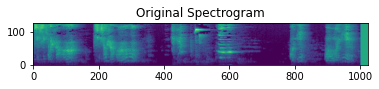

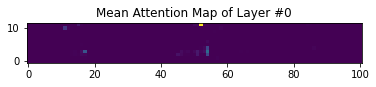

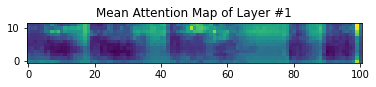

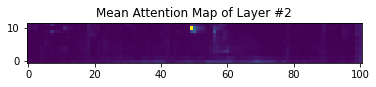

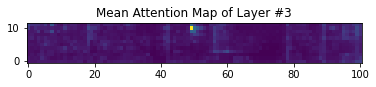

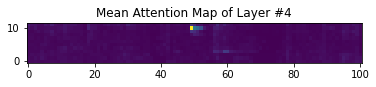

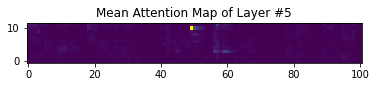

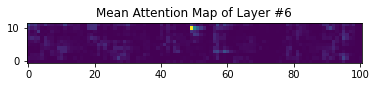

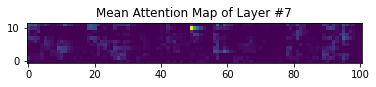

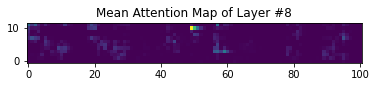

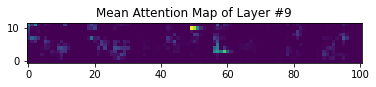

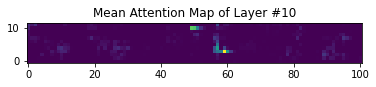

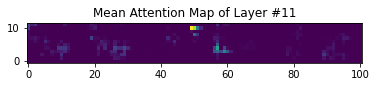

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(feats_data[0].t().cpu(), origin='lower')
plt.title('Original Spectrogram')
plt.show()
plt.close()
# Make the prediction
with torch.no_grad():
  with autocast():
    att_list = audio_model.module.forward_visualization(feats_data)
for i in range(len(att_list)):
  att_list[i] = att_list[i].data.cpu().numpy()
  att_list[i] = np.mean(att_list[i][0], axis=0)
  att_list[i] = np.mean(att_list[i][0:2], axis=0)
  att_list[i] = att_list[i][2:].reshape(12, 101)
  plt.imshow(att_list[i], origin='lower')
  plt.title('Mean Attention Map of Layer #{:d}'.format(i))
  plt.show()
  plt.close()

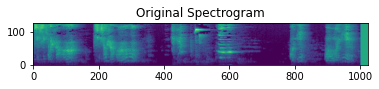

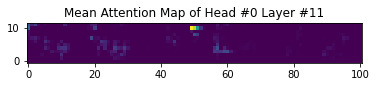

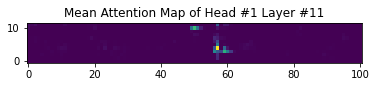

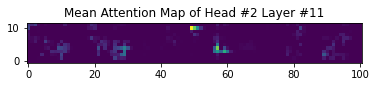

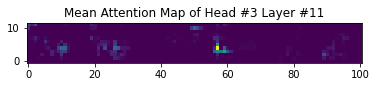

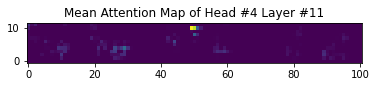

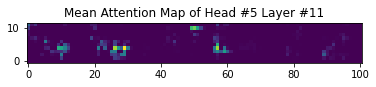

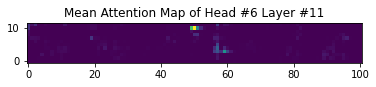

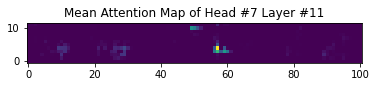

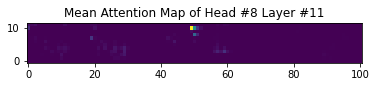

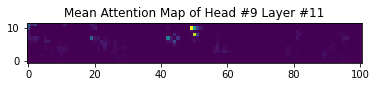

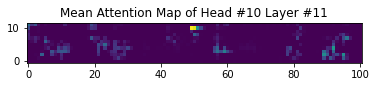

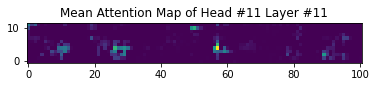

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(feats_data[0].t().cpu(), origin='lower')
plt.title('Original Spectrogram')
plt.show()
plt.close()
# Make the prediction
with torch.no_grad():
  with autocast():
    att_list = audio_model.module.forward_visualization(feats_data)

# the layer of interest
i = 11

att_map = att_list[i].data.cpu().numpy()
att_map = att_map[0]
att_map = np.mean(att_map[:, 0:2, :], axis=1)
att_map = att_map[:, 2:].reshape(12, 12, 101)
for j in range(12):
  plt.imshow(att_map[j], origin='lower')
  plt.title('Mean Attention Map of Head #{:d} Layer #{:d}'.format(j, i))
  plt.show()
  plt.close()